In [1]:
"""
Pseudocode for NMSE COC

1. Import necessary packages.
2. Generate theoretical EPW and IAW spectra (S).
3. Fit S.
    3.1. Define NMSE COC.
    3.2. Generate initial EPW S'.
    3.3. Perform iterative fitting for EPW and extract parameters.
    3.4. Repeat previous 2 steps for IAW.
4. Save all required information to fit to hdf5 file (Not done here).

Order in which parameters will vary (Most senstiive to least sensitive):
ions: n -> efract -> temps -> vds
Ions: ifracts -> vds -> temps
"""

"\nPseudocode for NMSE COC\n\n1. Import necessary packages.\n2. Generate theoretical EPW and IAW spectra (S).\n3. Fit S.\n    3.1. Define NMSE COC.\n    3.2. Generate initial EPW S'.\n    3.3. Perform iterative fitting for EPW and extract parameters.\n    3.4. Repeat previous 2 steps for IAW.\n4. Save all required information to fit to hdf5 file (Not done here).\n\nOrder in which parameters will vary (Most senstiive to least sensitive):\nions: n -> efract -> temps -> vds\nIons: ifracts -> vds -> temps\n"

## M1: Fit ion fractions using lr of 1e-4 w/o softmax. In other version of this script, we will use softmax to compare performance.

# 1. Import Necessary Packages

In [2]:
%matplotlib inline

import torch
from torch import Tensor
import torch.nn.functional as F

import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import trange

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
# import warnings

!pip install lmfit
!pip install git+https://github.com/BradynKlein/ThomsonScattering.git
!pip install numba
!pip install numba_scipy

!pip install git+https://github.com/v-bhelande/ts_repo.git

from lmfit import Parameters

from plasmapy.formulary import Maxwellian_1D
from plasmapy.diagnostics import thomson
from plasmapy.diagnostics import cpu_autodiff_thomson

import matplotlib.pyplot as plt
import astropy.constants as const

from scipy.special import expit, gamma
import random

import h5py

# Make all tensors float64 by default
torch.set_default_dtype(torch.float64)

  Cloning https://github.com/BradynKlein/ThomsonScattering.git to /tmp/pip-req-build-m3sq9sea
  Running command git clone --filter=blob:none --quiet https://github.com/BradynKlein/ThomsonScattering.git /tmp/pip-req-build-m3sq9sea
  Resolved https://github.com/BradynKlein/ThomsonScattering.git to commit 2fb831b5672b154b45e7474ed701d5545fced41e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for plasmapy: filename=plasmapy-0.1.dev3053+g2fb831b-py3-none-any.whl size=8795247 sha256=5be113dbc222a14c8a25aec0c6918cab79077d39fc551fbeba09b29c171d4a84
  Stored in directory: /tmp/pip-ephem-wheel-cache-98tw6iq5/wheels/37/a5/64/791495890df9c2e6c789c73aa9ee7a83c871f9ae5b5b1a9eee
Successfully built plasmapy
  Attempting uninstall: plasmapy
    Found existing installation: plasmapy 0.7.dev506+g66e6300f
    Uninstalling plasmapy-0.7.dev506+g66e6300f:
      Successfully uninstalled plasmapy-0.7.dev506+

In [3]:
if torch.cuda.is_available():
    print("Number of GPUs:" + str(torch.cuda.device_count()))
    for i in range(torch.cuda.device_count()):
        print("Device"  + str(i) + ": "  + str(torch.cuda.get_device_name(i)))
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        device2 = torch.device('cuda:1')
    else:
        device2 = None
else:
    print("Number of GPUs: 0")
    device = torch.device('cpu')
    device2 = None

torch.set_default_device('cuda') 

Number of GPUs:2
Device0: NVIDIA GeForce RTX 4070
Device1: NVIDIA GeForce RTX 4070


In [4]:
# All surface level user inputs must be declared here

# Declare true plasma params (TPP)
# [n]: m^-3
# [T]: eV
# [vd]: m/s

n_true = 1.0e25 # m^-3

e_c0_true = 1.
e_c1_true = 0.
e_c2_true = 0.
e_c3_true = 0.
e_c4_true = 0.
e_c5_true = 0.
e_c6_true = 0.
e_c7_true = 0.
e_c8_true = 0.
e_c9_true = 0.
e_c10_true = 0.
e_c11_true = 0.
e_c12_true = 0.
e_c13_true = 0.
e_c14_true = 0.
e_c15_true = 0.
e_c16_true = 0.
e_c17_true = 0.
e_c18_true = 0.
e_c19_true = 0.
e_c20_true = 0.
e_c21_true = 0.
e_c22_true = 0.
e_c23_true = 0.
e_c24_true = 0.
e_c25_true = 0.
e_c26_true = 0.
e_c27_true = 0.

e_vd_true = 0.
e_scale_true = 0.6 * (2 * 8.2544e3 * 11605 * 500 * 1836)**(0.5)

i_c0_true = 1.
i_c1_true = 0.
i_c2_true = 0.
i_c3_true = 0.
i_c4_true = 0.
i_c5_true = 0.
i_c6_true = 0.
i_c7_true = 0.
i_c8_true = 0.
i_c9_true = 0.
i_c10_true = 0.
i_c11_true = 0.
i_c12_true = 0.
i_c13_true = 0.
i_c14_true = 0.
i_c15_true = 0.
i_c16_true = 0.
i_c17_true = 0.
i_c18_true = 0.
i_c19_true = 0.
i_c20_true = 0.
i_c21_true = 0.
i_c22_true = 0.
i_c23_true = 0.
i_c24_true = 0.
i_c25_true = 0.
i_c26_true = 0.
i_c27_true = 0.

i_vd_true = 2.5e5
i_scale_true = 0.6 * (2 * 8.2544e3 * 11605 * 400)**(0.5)


# Construct TPP as a dictionary of form: [n, e_T, e_p, e_vd, i0_vd, i0_p, i0_T]
TPP = {
    "n_true"       : n_true,
    "e_c0_true"    : e_c0_true,
    "e_c1_true"    : e_c1_true,
    "e_c2_true"    : e_c2_true,
    "e_c3_true"    : e_c3_true,
    "e_c4_true"    : e_c4_true,
    "e_c5_true"    : e_c5_true,
    "e_c6_true"    : e_c6_true,
    "e_c7_true"    : e_c7_true,
    "e_c8_true"    : e_c8_true,
    "e_c9_true"    : e_c9_true,
    "e_c10_true"   : e_c10_true,
    "e_c11_true"   : e_c11_true,
    "e_c12_true"   : e_c12_true,
    "e_c13_true"   : e_c13_true,
    "e_c14_true"   : e_c14_true,
    "e_c15_true"   : e_c15_true,
    "e_c16_true"   : e_c16_true,
    "e_c17_true"   : e_c17_true,
    "e_c18_true"   : e_c18_true,
    "e_c19_true"   : e_c19_true,
    "e_c20_true"   : e_c20_true,
    "e_c21_true"   : e_c21_true,
    "e_c22_true"   : e_c22_true,
    "e_c23_true"   : e_c23_true,
    "e_c24_true"   : e_c24_true,
    "e_c25_true"   : e_c25_true,
    "e_c26_true"   : e_c26_true,
    "e_c27_true"   : e_c27_true,
    "e_vd_true"    : e_vd_true,
    "e_scale_true" : e_scale_true,

    "i_c0_true"    : i_c0_true,
    "i_c1_true"    : i_c1_true,
    "i_c2_true"    : i_c2_true,
    "i_c3_true"    : i_c3_true,
    "i_c4_true"    : i_c4_true,
    "i_c5_true"    : i_c5_true,
    "i_c6_true"    : i_c6_true,
    "i_c7_true"    : i_c7_true,
    "i_c8_true"    : i_c8_true,
    "i_c9_true"    : i_c9_true,
    "i_c10_true"   : i_c10_true,
    "i_c11_true"   : i_c11_true,
    "i_c12_true"   : i_c12_true,
    "i_c13_true"   : i_c13_true,
    "i_c14_true"   : i_c14_true,
    "i_c15_true"   : i_c15_true,
    "i_c16_true"   : i_c16_true,
    "i_c17_true"   : i_c17_true,
    "i_c18_true"   : i_c18_true,
    "i_c19_true"   : i_c19_true,
    "i_c20_true"   : i_c20_true,
    "i_c21_true"   : i_c21_true,
    "i_c22_true"   : i_c22_true,
    "i_c23_true"   : i_c23_true,
    "i_c24_true"   : i_c24_true,
    "i_c25_true"   : i_c25_true,
    "i_c26_true"   : i_c26_true,
    "i_c27_true"   : i_c27_true,
    "i_vd_true"    : i_vd_true,
    "i_scale_true" : i_scale_true,
}

# Keep track of number of EPW and IAW params
NUM_ELECTRON_PARAMS = 31
NUM_ION_PARAMS = 30  # Since we never fit i2_fract by itself
NUM_PARAMS = NUM_ELECTRON_PARAMS + NUM_ION_PARAMS

# Choose number of parameters to vary (Done in order: [n, e_n1, e_T2, e_T1, e_vd2, e_vd1, i1_fract, i0_fract, i2_vd, i1_vd, i0_vd])
NUM_FREE_PARAMS = NUM_PARAMS

"""
# Declare file path to write hdf5 file and keys for theoretical + best fit data
FILE_PATH = "/Users/vedang/Desktop/Plasma_Research/output_files/sg_file_test_dict.hdf5"
THEORETICAL_KEY = "theoretical_data"
BEST_FIT_KEY = "best_fit_data"
sg_file = h5py.File(FILE_PATH, "w")"""

# Declare cutoff criteria for spectra fitting here
# Defined as difference between consecutive iterations
EPW_CUTOFF_CRITERIA = 1e-8
IAW_CUTOFF_CRITERIA = EPW_CUTOFF_CRITERIA * 10

# Set a flag for minimum number of iterations
MIN_NUM_ITERS = 500

In [5]:
# Generate param keys automatically from TPP
param_keys = []
for key in TPP.keys():
    param_keys.append(key[:-len("_true")])

electron_param_keys = []
for key in param_keys[:NUM_ELECTRON_PARAMS]:
    if key == "n": electron_param_keys.append("ln_"+key)
    elif key[0] == "e":
        if "scale" in key: electron_param_keys.append("ln_"+key)
        else: electron_param_keys.append(key)
    else: raise ValueError("Invalid param key entered, check TPP dictionary!")

ion_param_keys = []
for key in param_keys[NUM_ELECTRON_PARAMS:]:
    if key[0] != "i": raise ValueError("Invalid param key entered, check TPP dictionary!")
    elif "scale" in key: ion_param_keys.append("ln_"+key)
    else:  ion_param_keys.append(key)

In [6]:
print(param_keys)
print(electron_param_keys)
print(ion_param_keys)

['n', 'e_c0', 'e_c1', 'e_c2', 'e_c3', 'e_c4', 'e_c5', 'e_c6', 'e_c7', 'e_c8', 'e_c9', 'e_c10', 'e_c11', 'e_c12', 'e_c13', 'e_c14', 'e_c15', 'e_c16', 'e_c17', 'e_c18', 'e_c19', 'e_c20', 'e_c21', 'e_c22', 'e_c23', 'e_c24', 'e_c25', 'e_c26', 'e_c27', 'e_vd', 'e_scale', 'i_c0', 'i_c1', 'i_c2', 'i_c3', 'i_c4', 'i_c5', 'i_c6', 'i_c7', 'i_c8', 'i_c9', 'i_c10', 'i_c11', 'i_c12', 'i_c13', 'i_c14', 'i_c15', 'i_c16', 'i_c17', 'i_c18', 'i_c19', 'i_c20', 'i_c21', 'i_c22', 'i_c23', 'i_c24', 'i_c25', 'i_c26', 'i_c27', 'i_vd', 'i_scale']
['ln_n', 'e_c0', 'e_c1', 'e_c2', 'e_c3', 'e_c4', 'e_c5', 'e_c6', 'e_c7', 'e_c8', 'e_c9', 'e_c10', 'e_c11', 'e_c12', 'e_c13', 'e_c14', 'e_c15', 'e_c16', 'e_c17', 'e_c18', 'e_c19', 'e_c20', 'e_c21', 'e_c22', 'e_c23', 'e_c24', 'e_c25', 'e_c26', 'e_c27', 'e_vd', 'ln_e_scale']
['i_c0', 'i_c1', 'i_c2', 'i_c3', 'i_c4', 'i_c5', 'i_c6', 'i_c7', 'i_c8', 'i_c9', 'i_c10', 'i_c11', 'i_c12', 'i_c13', 'i_c14', 'i_c15', 'i_c16', 'i_c17', 'i_c18', 'i_c19', 'i_c20', 'i_c21', 'i_c22', '

# 2. Generate Theoretical EPW and IAW Spectra (S)

In [7]:
# Generate Maxwellian vdfs
def maxwellian_e(v, T, vd):   # Distribution for electrons
    T_K = T * 11605
    vth = np.sqrt(2 * 1.5156e7 * T_K)
    exp_term = -(v - vd) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

def bimaxwellian_e(v, T1, vd1, T2, vd2, n1):
    return n1 * maxwellian_e(v, T1, vd1) + (1 - n1) * maxwellian_e(v, T2, vd2)

def maxwellian_H(v, T, vd):   # Distribution for hydrogen ions
    T_K = T * 11605
    vth = np.sqrt(2 * 1.5156e7 * T_K / 1836)
    exp_term = -(v - vd) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

def maxwellian_C(v, T, vd):   # Distribution for carbon ions
    T_K = T * 11605
    vth = np.sqrt(2 * 1.5156e7 * T_K / 1836 / 12)
    exp_term = -(v - vd) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

# Generate Super-Gaussian VDFs
def supergaussian_e(v, T, vd, p):
    T_K = T * 11605
    vth = np.sqrt(2 * 8.2544e3 * T_K * 1836)  # 1836 = Ratio of electron to proton mass
    vdf_unnormalized = np.exp(-np.abs((v - vd)) ** p / np.abs(vth) ** p)
    return vdf_unnormalized / np.trapz(vdf_unnormalized, v)

def supergaussian_H(v, T, vd, p):
    T_K = T * 11605
    vth = np.sqrt(2 * 8.2544e3 * T_K)
    vdf_unnormalized = np.exp(-np.abs((v - vd)  / (vth)) ** p)
    return vdf_unnormalized / np.trapz(vdf_unnormalized, v)

In [8]:
# Kwargs to pass to spectral_density_arbdist() function
probe_wavelength = 532 * u.nm
epw_wavelengths = np.linspace(probe_wavelength.value - 100, probe_wavelength.value + 100, num=200) * u.nm
iaw_wavelengths = np.linspace(probe_wavelength.value - 3, probe_wavelength.value + 3, num=200) * u.nm

notch = np.array([520, 540])

#ve = np.linspace(-5e7, 5e7, 500)
#vH = np.linspace(-2e6, 2e6, 500)
ve = np.linspace(-5e7, 5e7, 500)
vH = np.linspace(-2e6, 2e6, 500)

# Treat pision plasma and ambient plasma electrons together since efract cannot be inputted
#fe_in = bimaxwellian_e(ve, TPP["e_T1_true"], TPP["e_vd1_true"], TPP["e_T2_true"], TPP["e_vd2_true"], TPP["e_n1_true"])

# Instantiate each ion distribution separately since we can input ifract
#fH_ambient = maxwellian_e(vH, TPP["i0_T_true"], TPP["i0_vd_true"])
#fH_piston = maxwellian_e(vH, TPP["i1_T_true"], TPP["i1_vd_true"])
#fC_piston = maxwellian_e(vH, TPP["i2_T_true"], TPP["i2_vd_true"])


fe_in = bimaxwellian_e(ve, 50, 0, 500, 5e5, 1/11)
fH_in = maxwellian_H(vH, 400, 5.0e5)
fC_in = maxwellian_C(vH, 400, 5.0e5)
#n = 4e18

n = TPP["n_true"] * 1e-6   # Convert density from m^-3 to cm^-3

In [9]:
# Generate theoretical spectra
alpha, epw_Pw_in = thomson.spectral_density_arbdist(
    wavelengths = epw_wavelengths,
    notches = [notch] * u.nm,
    probe_wavelength = probe_wavelength,
    e_velocity_axes = [ve] * u.m / u.s,
    i_velocity_axes = [vH, vH] * u.m / u.s,
    efn = [fe_in] * u.s / u.m,
    ifn = [fH_in, fC_in] * u.s / u.m,
    n = n * u.cm ** -3,
    scattered_power = True,
    ion_species = ["p", "C-12 5+"],
    ifract = [9/10, 1/10]
)

alpha, iaw_Pw_in = thomson.spectral_density_arbdist(
    wavelengths = iaw_wavelengths,
    probe_wavelength = probe_wavelength,
    e_velocity_axes = [ve] * u.m / u.s,
    i_velocity_axes = [vH, vH] * u.m / u.s,
    efn = [fe_in] * u.s / u.m,
    ifn = [fH_in, fC_in] * u.s / u.m,
    n = n * u.cm ** -3,
    scattered_power = True,
    ion_species = ["p", "C-12 5+"],
    ifract = [9/10, 1/10]
)

# Noise
np.random.seed(123)
#epw_Pw_in += np.random.normal(loc = 0, scale = 0.05 * max(epw_Pw_in), size = len(epw_wavelengths))
#iaw_Pw_in += np.random.normal(loc = 0, scale = 0.05 * max(iaw_Pw_in), size = len(iaw_wavelengths))

# Targets
epw_target = epw_Pw_in
iaw_target = iaw_Pw_in

# Convert 'em to tensors
epw_target = torch.from_numpy(epw_target)
iaw_target = torch.from_numpy(iaw_target)

# Statically define sum of theoretical spectra to be used in loss function
epw_sum = torch.sum(torch.square(epw_target))
iaw_sum = torch.sum(torch.square(iaw_target))

In [10]:
#print("EPW S:", epw_target)
#print("IAW S:", iaw_target)

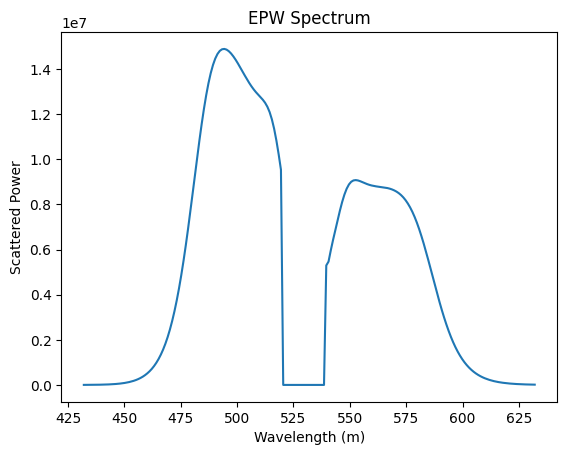

In [11]:
# Plot EPW spectrum
plt.plot(epw_wavelengths, epw_target.numpy())
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("EPW Spectrum")
plt.show()

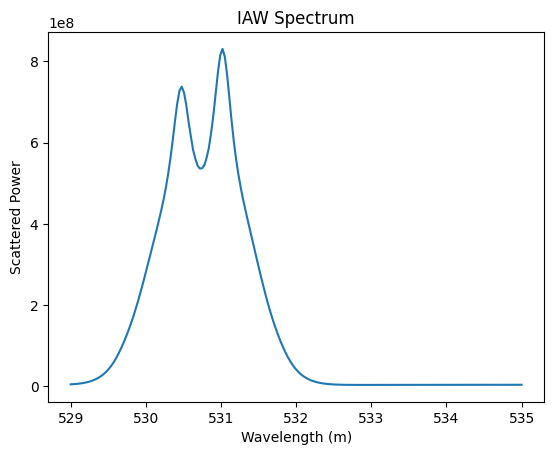

In [12]:
# Plot IAW spectrum
plt.plot(iaw_wavelengths, iaw_target.numpy())
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("IAW Spectrum")
plt.show()

# 3. Fit S

Parameters to optimize: 15
1. Electron velocities (2), ion velocities (3)
2. Electron temperatures (2), ion temperatures (3)
3. Electron fraction (1), ion fractions (3)
4. Density (1)

In [13]:
# Define Maxwellian functions to be compatible with PyTorch
def maxwellian_e_TORCH(v, T, vd):
    T_K = T * 11605
    vth = torch.sqrt(2 * 1.5156e7 * T_K)
    exp_term = -1. * torch.square(v - vd) / torch.square(vth)
    return torch.exp(exp_term) / torch.sqrt(torch.pi * torch.square(vth))    # Normalizes distribution

def maxwellian_H_TORCH(v, T, vd):
    T_K = T * 11605
    vth = torch.sqrt(2 * 1.5156e7 * T_K / 1836)
    exp_term = -1. * torch.square(v - vd) / torch.square(vth)
    return torch.exp(exp_term) / torch.sqrt(torch.pi * torch.square(vth))

def maxwellian_C_TORCH(v, T, vd):
    T_K = T * 11605
    vth = torch.sqrt(2 * 1.5156e7 * T_K / 1836 / 12)
    exp_term = -1. * torch.square(v - vd) / torch.square(vth)
    return torch.exp(exp_term) / torch.sqrt(torch.pi * torch.square(vth))

def bimaxwellian_e_TORCH(v, T1, vd1, T2, vd2, n1):
    return n1 * maxwellian_e_TORCH(v, T1, vd1) + (1 - n1) * maxwellian_e_TORCH(v, T2, vd2)

In [14]:
# Generate initial guess parameters to be within 50% of true values
init_guesses = {}
TPP_keys = list(TPP.keys())


def rand1(x):
    random.seed(123)   # Keep initial random guesses constant for testing purposes
    return random.uniform(x-(0.01*x), x+(0.01*x))
def rand20(x):
    random.seed(123)   # Keep initial random guesses constant for testing purposes
    return random.uniform(x-(0.2*x), x+(0.2*x))

if NUM_FREE_PARAMS == NUM_PARAMS:
    for i in range(NUM_PARAMS):
        rand_val = (TPP[TPP_keys[i]])                                 #rand here
        init_guesses[param_keys[i]] = rand_val
else:
    for i in range(NUM_FREE_PARAMS):
        rand_val = (TPP[TPP_keys[i]])                                 #rand here
        init_guesses[param_keys[i]] = rand_val
    for i in range(NUM_PARAMS-NUM_FREE_PARAMS+1):
        index = NUM_FREE_PARAMS+i-1
        init_guesses[param_keys[index]] = TPP[TPP_keys[index]]

In [15]:
init_guesses_keys = list(init_guesses.keys())

# Separate electron and ion params into their own dictionaries
electron_params = {}
for i in range(NUM_ELECTRON_PARAMS):
    if "ln" in electron_param_keys[i]: electron_params[electron_param_keys[i]] = torch.log(torch.tensor([init_guesses[init_guesses_keys[i]]]))
    else: electron_params[electron_param_keys[i]] = torch.tensor([init_guesses[init_guesses_keys[i]]])

ion_params = {}
for i in range(NUM_ION_PARAMS):
    if "ln" in ion_param_keys[i]: ion_params[ion_param_keys[i]] = torch.log(torch.tensor([init_guesses[init_guesses_keys[NUM_ELECTRON_PARAMS+i]]]))
    else: ion_params[ion_param_keys[i]] = torch.tensor([init_guesses[init_guesses_keys[NUM_ELECTRON_PARAMS+i]]])

print(ion_params)

{'i_c0': tensor([1.], device='cuda:0'), 'i_c1': tensor([0.], device='cuda:0'), 'i_c2': tensor([0.], device='cuda:0'), 'i_c3': tensor([0.], device='cuda:0'), 'i_c4': tensor([0.], device='cuda:0'), 'i_c5': tensor([0.], device='cuda:0'), 'i_c6': tensor([0.], device='cuda:0'), 'i_c7': tensor([0.], device='cuda:0'), 'i_c8': tensor([0.], device='cuda:0'), 'i_c9': tensor([0.], device='cuda:0'), 'i_c10': tensor([0.], device='cuda:0'), 'i_c11': tensor([0.], device='cuda:0'), 'i_c12': tensor([0.], device='cuda:0'), 'i_c13': tensor([0.], device='cuda:0'), 'i_c14': tensor([0.], device='cuda:0'), 'i_c15': tensor([0.], device='cuda:0'), 'i_c16': tensor([0.], device='cuda:0'), 'i_c17': tensor([0.], device='cuda:0'), 'i_c18': tensor([0.], device='cuda:0'), 'i_c19': tensor([0.], device='cuda:0'), 'i_c20': tensor([0.], device='cuda:0'), 'i_c21': tensor([0.], device='cuda:0'), 'i_c22': tensor([0.], device='cuda:0'), 'i_c23': tensor([0.], device='cuda:0'), 'i_c24': tensor([0.], device='cuda:0'), 'i_c25': 

In [16]:
# Attach gradients to plasma params depending on number of free params set
if NUM_FREE_PARAMS >= NUM_ELECTRON_PARAMS:
    for param in electron_params: electron_params[param].requires_grad=True
else:
    for i in range(NUM_FREE_PARAMS):
        electron_params[electron_param_keys[i]].requires_grad=True

## 3.1. Define NMSE Loss Function

In [17]:
def dist_score(Skw_Prime, Skw):
    mse = F.mse_loss(Skw_Prime, Skw)
    loss = (mse/torch.var(Skw))*100
    loss.backward()
    return loss

def nmse(Skw_Prime, Skw):
    mse = F.mse_loss(Skw_Prime, Skw)
    norm_mse = (mse/torch.var(Skw))*100
    return norm_mse

def error(observed_val, true_val):
    return 100*(np.abs((observed_val-true_val))/true_val)

## 3.2. Generate Initial EPW S'

In [18]:
# Declare S(k,w) arguments to pass to forward model

probe_wavelength_TORCH = 532

# Hard convert wavelengths to nm to match Bryan's code
epw_wavelengths_TORCH = torch.linspace(probe_wavelength_TORCH - 100, probe_wavelength_TORCH + 100, steps=200, dtype=torch.float64) * 1e-9  # * u.nm
iaw_wavelengths_TORCH = torch.linspace(probe_wavelength_TORCH - 3, probe_wavelength_TORCH + 3, steps=200, dtype=torch.float64) * 1e-9 # * u.nm
ve_TORCH = torch.linspace(-5e7, 5e7, steps=500, dtype=torch.float64)
vH_TORCH = torch.linspace(-2e6, 2e6, steps=500, dtype=torch.float64)

probe_wavelength_TORCH *= 1e-9 # u.nm

epw_notch = torch.tensor([[520, 540]])
epw_notches = epw_notch * 1e-9
iaw_notch = None

e_velocity_axis_TORCH = ve_TORCH.clone().detach()
e_velocity_axes_TORCH = [e_velocity_axis_TORCH]

i_velocity_axis_TORCH = vH_TORCH.clone().detach()
#i_velocity_axes_TORCH = [i_velocity_axis_TORCH, i_velocity_axis_TORCH, i_velocity_axis_TORCH]
i_velocity_axes_TORCH = [i_velocity_axis_TORCH]

efract_TORCH = torch.tensor([1.], dtype=torch.float64)
ifract_TORCH = torch.tensor([1.], dtype=torch.float64)

probe_vec_TORCH = torch.tensor([1, 0, 0], dtype=torch.float64)
scatter_vec_TORCH = torch.tensor([0, 1, 0], dtype=torch.float64)
scattered_power_TORCH = True
ion_species_TORCH = ["p"]
#??? what do we do with ion species ???

In [19]:
# Construct derivative matrices to perform first order and second order differentiation

# Computes derivatives of order 1
finDiffMat1 = torch.zeros(len(ve_TORCH), len(ve_TORCH))

# Forward difference elements
finDiffMat1[0][0] = -25./12.
finDiffMat1[0][1] = 4.
finDiffMat1[0][2] = -3.
finDiffMat1[0][3] = 4./3.
finDiffMat1[0][4] = -1./4.

finDiffMat1[1][1] = -25./12.
finDiffMat1[1][2] = 4.
finDiffMat1[1][3] = -3.
finDiffMat1[1][4] = 4./3.
finDiffMat1[1][5] = -1./4.

# Backward difference elements
finDiffMat1[-1][-1] = 25./12.
finDiffMat1[-1][-2] = -4.
finDiffMat1[-1][-3] = 3.
finDiffMat1[-1][-4] = -4./3.
finDiffMat1[-1][-5] = 1./4.

finDiffMat1[-2][-2] = 25./12.
finDiffMat1[-2][-3] = -4.
finDiffMat1[-2][-4] = 3.
finDiffMat1[-2][-5] = -4./3.
finDiffMat1[-2][-6] = 1./4.

# Centered difference elements
for i in range(2, len(finDiffMat1)-2):
    finDiffMat1[i][i-2] = 1./12.
    finDiffMat1[i][i-1] = -8./12.
    finDiffMat1[i][i] = 0.
    finDiffMat1[i][i+1] = 8./12.
    finDiffMat1[i][i+2] = -1./12.

# Computes derivatives of order 2
finDiffMat2 = torch.zeros(len(ve_TORCH), len(ve_TORCH))

# Forward difference elements
finDiffMat2[0][0] = 15./4.
finDiffMat2[0][1] = -77./6.
finDiffMat2[0][2] = 107./6.
finDiffMat2[0][3] = -13.
finDiffMat2[0][4] = 61./12.
finDiffMat2[0][5] = -5./6.

finDiffMat2[1][1] = 15./4.
finDiffMat2[1][2] = -77./6.
finDiffMat2[1][3] = 107./6.
finDiffMat2[1][4] = -13.
finDiffMat2[1][5] = 61./12.
finDiffMat2[1][6] = -5./6.

# Backward difference elements
finDiffMat2[-1][-1] = 15./4.
finDiffMat2[-1][-2] = -77./6.
finDiffMat2[-1][-3] = 107./6.
finDiffMat2[-1][-4] = -13.
finDiffMat2[-1][-5] = 61./12.
finDiffMat2[-1][-6] = -5./6.

finDiffMat2[-2][-2] = 15./4.
finDiffMat2[-2][-3] = -77./6.
finDiffMat2[-2][-4] = 107./6.
finDiffMat2[-2][-5] = -13.
finDiffMat2[-2][-6] = 61./12.
finDiffMat2[-2][-7] = -5./6.

# Centered difference elements
for i in range(2, len(finDiffMat2)-2):
    finDiffMat2[i][i-2] = -1./12.
    finDiffMat2[i][i-1] = 4./3.
    finDiffMat2[i][i] = -5./2.
    finDiffMat2[i][i+1] = 4./3.
    finDiffMat2[i][i+2] = -1./12.

derivative_matrices = [finDiffMat1, finDiffMat2]

# Sum of Maxwellians

In [20]:
import torch
import math

def make_hermite_functions():
    hermite_funcs = []

    def norm(n):
        return ((-1.0)**n) / math.sqrt((2 ** n) * math.factorial(n) * math.sqrt(math.pi))


    hermite_funcs = []

    hermite_funcs.append(lambda x: norm(0) * torch.exp(-x**2 / 2) * (1.0))
    hermite_funcs.append(lambda x: norm(1) * torch.exp(-x**2 / 2) * (2.0*x))
    hermite_funcs.append(lambda x: norm(2) * torch.exp(-x**2 / 2) * (4.0*x**2 - 2.0))
    hermite_funcs.append(lambda x: norm(3) * torch.exp(-x**2 / 2) * (8.0*x**3 - 12.0*x))
    hermite_funcs.append(lambda x: norm(4) * torch.exp(-x**2 / 2) * (16.0*x**4 - 48.0*x**2 + 12.0))
    hermite_funcs.append(lambda x: norm(5) * torch.exp(-x**2 / 2) * (32.0*x**5 - 160.0*x**3 + 120.0*x))
    hermite_funcs.append(lambda x: norm(6) * torch.exp(-x**2 / 2) * (64.0*x**6 - 480.0*x**4 + 720.0*x**2 - 120.0))
    hermite_funcs.append(lambda x: norm(7) * torch.exp(-x**2 / 2) * (128.0*x**7 - 1344.0*x**5 + 3360.0*x**3 - 1680.0*x))
    hermite_funcs.append(lambda x: norm(8) * torch.exp(-x**2 / 2) * (256.0*x**8 - 3584.0*x**6 + 13440.0*x**4 - 13440.0*x**2 + 1680.0))
    hermite_funcs.append(lambda x: norm(9) * torch.exp(-x**2 / 2) * (512.0*x**9 - 9216.0*x**7 + 48384.0*x**5 - 80640.0*x**3 + 30240.0*x))
    hermite_funcs.append(lambda x: norm(10) * torch.exp(-x**2 / 2) * (1024.0*x**10 - 23040.0*x**8 + 161280.0*x**6 - 403200.0*x**4 + 302400.0*x**2 - 30240.0))
    hermite_funcs.append(lambda x: norm(11) * torch.exp(-x**2 / 2) * (2048.0*x**11 - 56320.0*x**9 + 506880.0*x**7 - 1774080.0*x**5 + 2217600.0*x**3 - 665280.0*x))
    hermite_funcs.append(lambda x: norm(12) * torch.exp(-x**2 / 2) * (4096.0*x**12 - 135168.0*x**10 + 1520640.0*x**8 - 7096320.0*x**6 + 13305600.0*x**4 - 7983360.0*x**2 + 665280.0))
    hermite_funcs.append(lambda x: norm(13) * torch.exp(-x**2 / 2) * (8192.0*x**13 - 319488.0*x**11 + 4392960.0*x**9 - 26357760.0*x**7 + 69189120.0*x**5 - 69189120.0*x**3 + 17297280.0*x))
    hermite_funcs.append(lambda x: norm(14) * torch.exp(-x**2 / 2) * (16384.0*x**14 - 745472.0*x**12 + 12300288.0*x**10 - 92252160.0*x**8 + 322882560.0*x**6 - 484323840.0*x**4 + 242161920.0*x**2 - 17297280.0))
    hermite_funcs.append(lambda x: norm(15) * torch.exp(-x**2 / 2) * (32768.0*x**15 - 1720320.0*x**13 + 33546240.0*x**11 - 307507200.0*x**9 + 1383782400.0*x**7 - 2905943040.0*x**5 + 2421619200.0*x**3 - 518918400.0*x))
    hermite_funcs.append(lambda x: norm(16) * torch.exp(-x**2 / 2) * (65536.0*x**16 - 3932160.0*x**14 + 89456640.0*x**12 - 984023040.0*x**10 + 5535129600.0*x**8 - 15498362880.0*x**6 + 19372953600.0*x**4 - 8302694400.0*x**2 + 518918400.0))
    hermite_funcs.append(lambda x: norm(17) * torch.exp(-x**2 / 2) * (131072.0*x**17 - 8912896.0*x**15 + 233963520.0*x**13 - 3041525760.0*x**11 + 20910489600.0*x**9 - 75277762560.0*x**7 + 131736084480.0*x**5 - 94097203200.0*x**3 + 17643225600.0*x))
    hermite_funcs.append(lambda x: norm(18) * torch.exp(-x**2 / 2) * (262144.0*x**18 - 20054016.0*x**16 + 601620480.0*x**14 - 9124577280.0*x**12 + 75277762560.0*x**10 - 338749931520.0*x**8 + 790416506880.0*x**6 - 846874828800.0*x**4 + 317578060800.0*x**2 - 17643225600.0))
    hermite_funcs.append(lambda x: norm(19) * torch.exp(-x**2 / 2) * (524288.0*x**19 - 44826624.0*x**17 + 1524105216.0*x**15 - 26671841280.0*x**13 + 260050452480.0*x**11 - 1430277488640.0*x**9 + 4290832465920.0*x**7 - 6436248698880.0*x**5 + 4022655436800.0*x**3 - 670442572800.0*x))
    hermite_funcs.append(lambda x: norm(20) * torch.exp(-x**2 / 2) * (1048576.0*x**20 - 99614720.0*x**18 + 3810263040.0*x**16 - 76205260800.0*x**14 + 866834841600.0*x**12 - 5721109954560.0*x**10 + 21454162329600.0*x**8 - 42908324659200.0*x**6 + 40226554368000.0*x**4 - 13408851456000.0*x**2 + 670442572800.0))
    hermite_funcs.append(lambda x: norm(21) * torch.exp(-x**2 / 2) * (2097152.0*x**21 - 220200960.0*x**19 + 9413591040.0*x**17 - 213374730240.0*x**15 + 2800543334400.0*x**13 - 21844238008320.0*x**11 + 100119424204800.0*x**9 - 257449947955200.0*x**7 + 337903056691200.0*x**5 - 187723920384000.0*x**3 + 28158588057600.0*x))
    hermite_funcs.append(lambda x: norm(22) * torch.exp(-x**2 / 2) * (4194304.0*x**22 - 484442112.0*x**20 + 23011000320.0*x**18 - 586780508160.0*x**16 + 8801707622400.0*x**14 - 80095539363840.0*x**12 + 440525466501120.0*x**10 - 1.4159747137536e+15*x**8 + 2.4779557490688e+15*x**6 - 2.064963124224e+15*x**4 + 619488937267200.0*x**2 - 28158588057600.0))
    hermite_funcs.append(lambda x: norm(23) * torch.exp(-x**2 / 2) * (8388608.0*x**23 - 1061158912.0*x**21 + 55710842880.0*x**19 - 1587759022080.0*x**17 + 26991903375360.0*x**15 - 283414985441280.0*x**13 + 1.84219740536832e+15*x**11 - 7.2372040925184e+15*x**9 + 1.62837092081664e+16*x**7 - 1.89976607428608e+16*x**5 + 9.4988303714304e+15*x**3 - 1.2952950506496e+15*x))
    hermite_funcs.append(lambda x: norm(24) * torch.exp(-x**2 / 2) * (16777216.0*x**24 - 2315255808.0*x**22 + 133706022912.0*x**20 - 4234024058880.0*x**18 + 80975710126080.0*x**16 - 971708521512960.0*x**14 + 7.36878962147328e+15*x**12 - 3.47385796440883e+16*x**10 + 9.77022552489984e+16*x**8 - 1.51981285942886e+17*x**6 + 1.13985964457165e+17*x**4 - 3.10870812155904e+16*x**2 + 1.2952950506496e+15))
    hermite_funcs.append(lambda x: norm(25) * torch.exp(-x**2 / 2) * (33554432.0*x**25 - 5033164800.0*x**23 + 318347673600.0*x**21 - 11142168576000.0*x**19 + 238163853312000.0*x**17 - 3.2390284050432e+15*x**15 + 2.8341498544128e+16*x**13 - 1.57902634745856e+17*x**11 + 5.4279030693888e+17*x**9 - 1.08558061387776e+18*x**7 + 1.13985964457165e+18*x**5 - 5.1811802025984e+17*x**3 + 6.476475253248e+16*x))
    hermite_funcs.append(lambda x: norm(26) * torch.exp(-x**2 / 2) * (67108864.0*x**26 - 10905190400.0*x**24 + 752458137600.0*x**22 - 28969638297600.0*x**20 + 688028909568000.0*x**18 - 1.05268423163904e+16*x**16 + 1.05268423163904e+17*x**14 - 6.84244750565376e+17*x**12 + 2.82250959608218e+18*x**10 - 7.05627399020544e+18*x**8 + 9.87878358628762e+18*x**6 - 6.73553426337792e+18*x**4 + 1.68388356584448e+18*x**2 - 6.476475253248e+16))
    hermite_funcs.append(lambda x: norm(27) * torch.exp(-x**2 / 2) * (134217728.0*x**27 - 23555211264.0*x**25 + 1766640844800.0*x**23 - 74493355622400.0*x**21 + 1.955450585088e+15*x**19 - 3.34382050050048e+16*x**17 + 3.78966323390054e+17*x**15 - 2.84224742542541e+18*x**13 + 1.38559561989489e+19*x**11 - 4.23376439412326e+19*x**9 + 7.62077590942188e+19*x**7 - 7.27437700444815e+19*x**5 + 3.03099041852006e+19*x**3 - 3.49729663675392e+18*x))

    

    # You can continue this pattern up to ψ₂₇...
    # For brevity, only 21 are listed here. Do you want me to complete the full 28?

    return hermite_funcs


hermite_functions = make_hermite_functions()

def reconstruct_from_coeffs(v, vd, scale, hermite_functions, *coeffs):
    """
    Reconstructs a function from Hermite coefficients.
    
    Inputs:
    - v: target grid (torch)
    - vd: velocity shift
    - scale: scaling factor
    - hermite_functions: list of precomputed Hermite function lambdas
    - coeffs: Hermite coefficients
    
    Returns:
    - Reconstructed normalized function on v
    """

    z = (v - vd) / scale
    reconstruction = torch.zeros_like(v)

    for n, cn in enumerate(coeffs):
        reconstruction += cn * hermite_functions[n](z)

    squared = reconstruction ** 2
    return squared / torch.trapz(squared, v)




# Generate Initial EPW's

In [21]:
# Call forward model function to generate initial S'
efn = reconstruct_from_coeffs(e_velocity_axis_TORCH, electron_params["e_vd"], torch.exp(electron_params["ln_e_scale"]), hermite_functions,
                           electron_params["e_c0"], electron_params["e_c1"], electron_params["e_c2"], electron_params["e_c3"],electron_params["e_c4"],
                           electron_params["e_c5"], electron_params["e_c6"], electron_params["e_c7"], electron_params["e_c8"],electron_params["e_c9"],
                           electron_params["e_c10"], electron_params["e_c11"],electron_params["e_c12"], electron_params["e_c13"],electron_params["e_c14"],
                           electron_params["e_c15"], electron_params["e_c16"],electron_params["e_c17"], electron_params["e_c18"],electron_params["e_c19"],
                           electron_params["e_c20"], electron_params["e_c21"],electron_params["e_c22"], electron_params["e_c23"],electron_params["e_c24"],
                           electron_params["e_c25"], electron_params["e_c26"],electron_params["e_c27"])

#fH_ambient = maxwellian_H_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i0_T"]), ion_params["i0_vd"])
#fH_piston = maxwellian_H_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i1_T"]), ion_params["i1_vd"])
#fC_piston = maxwellian_C_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i2_T"]), ion_params["i2_vd"])

ifn = reconstruct_from_coeffs(i_velocity_axis_TORCH, ion_params["i_vd"], torch.exp(ion_params["ln_i_scale"]), hermite_functions,
                           ion_params["i_c0"], ion_params["i_c1"], ion_params["i_c2"], ion_params["i_c3"],ion_params["i_c4"],
                           ion_params["i_c5"], ion_params["i_c6"], ion_params["i_c7"], ion_params["i_c8"],ion_params["i_c9"],
                           ion_params["i_c10"], ion_params["i_c11"],ion_params["i_c12"], ion_params["i_c13"],ion_params["i_c14"],
                           ion_params["i_c15"], ion_params["i_c16"],ion_params["i_c17"], ion_params["i_c18"],ion_params["i_c19"],
                           ion_params["i_c20"], ion_params["i_c21"],ion_params["i_c22"], ion_params["i_c23"],ion_params["i_c24"],
                           ion_params["i_c25"], ion_params["i_c26"],ion_params["i_c27"])


efn_epw = [efn]
#ifn_epw = [fH_ambient, fH_piston, fC_piston]
ifn_epw = [ifn]

n_TORCH = torch.exp(electron_params["ln_n"])

#ifract_TORCH = [ion_params["i0_fract"], ion_params["i1_fract"], ion_params["i2_fract"]]

# Call forward model function to generate initial EPW S'
_, Skw_arbdist_epw = cpu_autodiff_thomson.spectral_density_arbdist(
    epw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    i_velocity_axes_TORCH,
    efn_epw,
    ifn_epw,
    derivative_matrices,
    torch.exp(electron_params["ln_n"]),
    epw_notches,
    efract_TORCH,
    ifract_TORCH,
    ion_species_TORCH,
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8
)

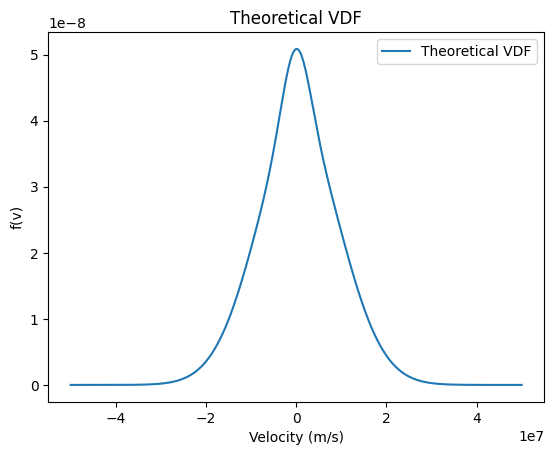

In [22]:
plt.plot(e_velocity_axis_TORCH.cpu().numpy(), fe_in, label='Theoretical VDF')

plt.title('Theoretical VDF')
plt.xlabel('Velocity (m/s)')
plt.ylabel('f(v)')
plt.legend()
plt.show()

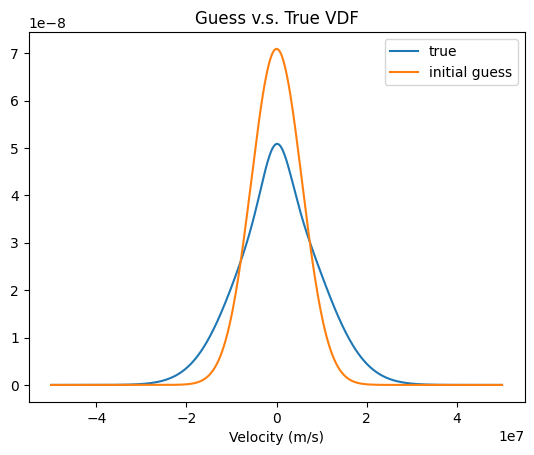

tensor(1., device='cuda:0', grad_fn=<DivBackward1>)


In [23]:
plt.plot(e_velocity_axis_TORCH.cpu().numpy(), fe_in, label='true')
plt.plot(e_velocity_axis_TORCH.cpu().numpy(), efn.detach().cpu().numpy(), label='initial guess')


plt.title('Guess v.s. True VDF')
plt.xlabel('Velocity (m/s)')
plt.legend()
plt.show()

print(torch.trapz(efn, e_velocity_axis_TORCH))

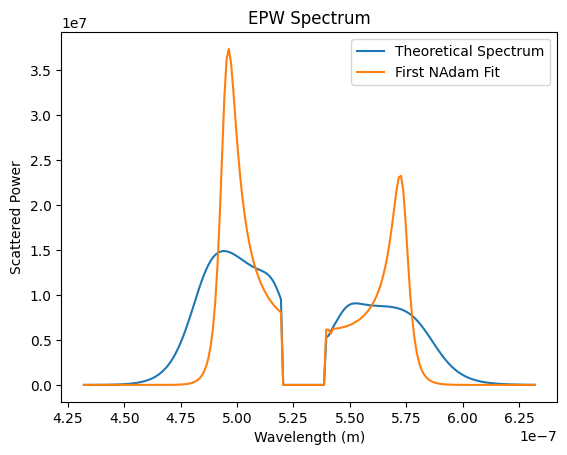

In [24]:
# Plot initial EPW S'
plt.plot(epw_wavelengths_TORCH.cpu().numpy(), epw_target, label="Theoretical Spectrum")
plt.plot(epw_wavelengths_TORCH.cpu().numpy(), Skw_arbdist_epw.detach().cpu().numpy(), label="First NAdam Fit")
plt.legend(loc="upper right")
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("EPW Spectrum")
plt.show()

## 3.3. Optimize EPW Spectrum

In [25]:
# Construct optimizer for EPW parameters
#opt_epw = torch.optim.NAdam([
#        {'params': (electron_params["ln_n"], electron_params["e_n1"], electron_params["ln_e_T2"], electron_params["ln_e_T1"], electron_params["e_vd1"]), 'lr':1e-3},
#        {'params': (electron_params["e_vd2"]), 'lr':100}
#      ], lr=1e-3, betas=[0.9985, 0.999])

In [26]:
from collections import defaultdict

# Auto-group based on parameter name prefixes
grouped_params = defaultdict(list)
for name, param in electron_params.items():
    if name.startswith("e_c"):
        grouped_params["coeffs"].append(param)
    elif name.startswith("e_s"):
        grouped_params["scale"].append(param)
    elif name.startswith("e_vd"):
        grouped_params["drift_velocities"].append(param)

opt_epw = torch.optim.NAdam([
    {'params': electron_params["ln_n"], 'lr': 1e-3},
    {'params': grouped_params["coeffs"], 'lr': 1e-3},
    {'params': grouped_params["scale"], 'lr': 1e-3},
    {'params': grouped_params["drift_velocities"], 'lr': 100}
], betas=[0.9985, 0.999])


In [27]:
# Calculate initial EPW loss
epw_target = epw_target.to(Skw_arbdist_epw.device)

epw_dist_hist = [Skw_arbdist_epw.detach().clone()]
epw_loss_hist = [dist_score(Skw_arbdist_epw, epw_target).detach()]
print(f"Initial EPW loss: {epw_loss_hist}")

Initial EPW loss: [tensor(105.9158, device='cuda:0')]


In [28]:
# Construct ion VDFs now to save redundant calls
#fH_ambient = maxwellian_H_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i0_T"]), ion_params["i0_vd"])
#fH_piston = maxwellian_H_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i1_T"]), ion_params["i1_vd"])
#fC_piston = maxwellian_C_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i2_T"]), ion_params["i2_vd"])
#ifn_epw = [fH_ambient, fH_piston, fC_piston]

ifn = reconstruct_from_coeffs(i_velocity_axis_TORCH, ion_params["i_vd"], torch.exp(ion_params["ln_i_scale"]), hermite_functions,
                           ion_params["i_c0"], ion_params["i_c1"], ion_params["i_c2"], ion_params["i_c3"],ion_params["i_c4"],
                           ion_params["i_c5"], ion_params["i_c6"], ion_params["i_c7"], ion_params["i_c8"],ion_params["i_c9"],
                           ion_params["i_c10"], ion_params["i_c11"],ion_params["i_c12"], ion_params["i_c13"],ion_params["i_c14"],
                           ion_params["i_c15"], ion_params["i_c16"],ion_params["i_c17"], ion_params["i_c18"],ion_params["i_c19"],
                           ion_params["i_c20"], ion_params["i_c21"],ion_params["i_c22"], ion_params["i_c23"],ion_params["i_c24"],
                           ion_params["i_c25"], ion_params["i_c26"],ion_params["i_c27"])

ifn_epw = [ifn]
ifract_TORCH = torch.tensor([1.], dtype=torch.float64)

#ifract_TORCH = [ion_params["i0_fract"], ion_params["i1_fract"], ion_params["i2_fract"]]

epw_counter = 0
while True:
    opt_epw.zero_grad()

    # Reconstruct electron velocity distribution using updated Ts and vds
    efn = reconstruct_from_coeffs(e_velocity_axis_TORCH, electron_params["e_vd"], torch.exp(electron_params["ln_e_scale"]), hermite_functions,
                           electron_params["e_c0"], electron_params["e_c1"], electron_params["e_c2"], electron_params["e_c3"],electron_params["e_c4"],
                           electron_params["e_c5"], electron_params["e_c6"], electron_params["e_c7"], electron_params["e_c8"],electron_params["e_c9"],
                           electron_params["e_c10"], electron_params["e_c11"],electron_params["e_c12"], electron_params["e_c13"],electron_params["e_c14"],
                           electron_params["e_c15"], electron_params["e_c16"],electron_params["e_c17"], electron_params["e_c18"],electron_params["e_c19"],
                           electron_params["e_c20"], electron_params["e_c21"],electron_params["e_c22"], electron_params["e_c23"],electron_params["e_c24"],
                           electron_params["e_c25"], electron_params["e_c26"],electron_params["e_c27"])


    efn_epw = [efn]

    _, Skw_arbdist_epw = cpu_autodiff_thomson.spectral_density_arbdist(
    epw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    i_velocity_axes_TORCH,
    efn_epw,
    ifn_epw,
    derivative_matrices,
    torch.exp(electron_params["ln_n"]),
    epw_notches,
    efract_TORCH,
    ifract_TORCH,
    ion_species_TORCH,
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8,
    )

    # Caculate NMSE
    epw_loss = dist_score(Skw_arbdist_epw, epw_target)
    opt_epw.step()

    # Append value to loss history
    epw_dist_hist.append(Skw_arbdist_epw.detach().clone())
    epw_loss_hist.append(float(epw_loss.detach()))

    epw_counter += 1

    # Check if criteria of convergence is met
    delta_NMSE = abs(epw_loss_hist[epw_counter] - epw_loss_hist[epw_counter-1])
    if delta_NMSE <= EPW_CUTOFF_CRITERIA and epw_counter != 1:
        print(f"Exiting loop after {epw_counter} iterations, loss is {delta_NMSE}")
        n_TORCH = torch.exp(electron_params["ln_n"])
        break

KeyboardInterrupt: 

Text(0.5, 1.0, 'EPW Loss History')

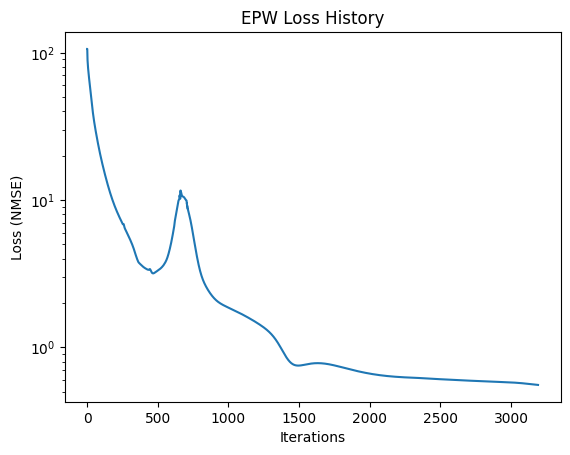

In [29]:
# Plot EPW loss history
#plt.semilogy(epw_loss_hist)#[-100:])
plt.semilogy([loss.item() if hasattr(loss, 'item') else loss for loss in epw_loss_hist])
plt.xlabel("Iterations")
plt.ylabel("Loss (NMSE)")
plt.title("EPW Loss History")

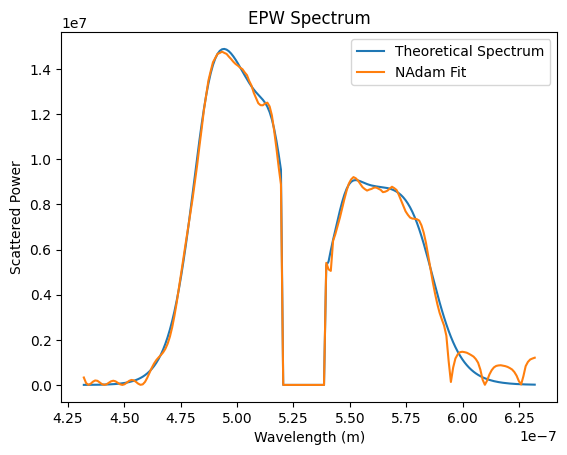

In [30]:
# Plot fitted EPW spectrum
plt.plot(epw_wavelengths_TORCH.cpu().numpy(), epw_target.cpu(), label="Theoretical Spectrum")
plt.plot(epw_wavelengths_TORCH.cpu().numpy(), Skw_arbdist_epw.detach().cpu().numpy(), label="NAdam Fit")
plt.legend(loc = "upper right")
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("EPW Spectrum")
plt.show()

e_vd_true =  tensor([-109749.7280], device='cuda:0')
e_scale_true =  tensor([7957065.1964], device='cuda:0')
e_c0_true =  tensor([0.1668], device='cuda:0')
e_c1_true =  tensor([0.1202], device='cuda:0')
e_c2_true =  tensor([0.4688], device='cuda:0')
e_c3_true =  tensor([0.0883], device='cuda:0')
e_c4_true =  tensor([0.0022], device='cuda:0')
e_c5_true =  tensor([-0.0013], device='cuda:0')
e_c6_true =  tensor([0.0775], device='cuda:0')
e_c7_true =  tensor([-0.0905], device='cuda:0')
e_c8_true =  tensor([-0.1621], device='cuda:0')
e_c9_true =  tensor([0.0693], device='cuda:0')
e_c10_true =  tensor([0.3234], device='cuda:0')
e_c11_true =  tensor([0.3154], device='cuda:0')
e_c12_true =  tensor([0.1369], device='cuda:0')
e_c13_true =  tensor([0.0235], device='cuda:0')
e_c14_true =  tensor([-0.0245], device='cuda:0')
e_c15_true =  tensor([-0.0239], device='cuda:0')
e_c16_true =  tensor([0.0705], device='cuda:0')
e_c17_true =  tensor([0.2292], device='cuda:0')
e_c18_true =  tensor([0.1773], d

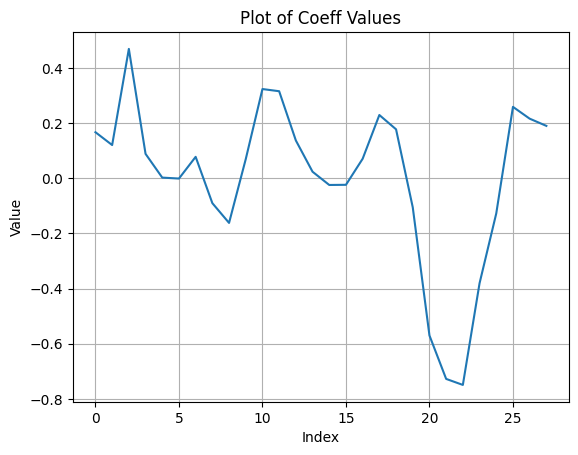

-0.030791768847235307


In [31]:
# Print optimized EPW parameters
e_vd_optim = electron_params["e_vd"].detach().clone()
e_scale_optim = torch.exp(electron_params["ln_e_scale"]).detach().clone()

e_c0_optim = electron_params["e_c0"].detach().clone()
e_c1_optim = electron_params["e_c1"].detach().clone()
e_c2_optim = electron_params["e_c2"].detach().clone()
e_c3_optim = electron_params["e_c3"].detach().clone()
e_c4_optim = electron_params["e_c4"].detach().clone()
e_c5_optim = electron_params["e_c5"].detach().clone()
e_c6_optim = electron_params["e_c6"].detach().clone()
e_c7_optim = electron_params["e_c7"].detach().clone()
e_c8_optim = electron_params["e_c8"].detach().clone()
e_c9_optim = electron_params["e_c9"].detach().clone()
e_c10_optim = electron_params["e_c10"].detach().clone()
e_c11_optim = electron_params["e_c11"].detach().clone()
e_c12_optim = electron_params["e_c12"].detach().clone()
e_c13_optim = electron_params["e_c13"].detach().clone()
e_c14_optim = electron_params["e_c14"].detach().clone()
e_c15_optim = electron_params["e_c15"].detach().clone()
e_c16_optim = electron_params["e_c16"].detach().clone()
e_c17_optim = electron_params["e_c17"].detach().clone()
e_c18_optim = electron_params["e_c18"].detach().clone()
e_c19_optim = electron_params["e_c19"].detach().clone()
e_c20_optim = electron_params["e_c20"].detach().clone()
e_c21_optim = electron_params["e_c21"].detach().clone()
e_c22_optim = electron_params["e_c22"].detach().clone()
e_c23_optim = electron_params["e_c23"].detach().clone()
e_c24_optim = electron_params["e_c24"].detach().clone()
e_c25_optim = electron_params["e_c25"].detach().clone()
e_c26_optim = electron_params["e_c26"].detach().clone()
e_c27_optim = electron_params["e_c27"].detach().clone()



n_optim = n_TORCH.detach().clone()

print("e_vd_true = ", e_vd_optim)
print("e_scale_true = ", e_scale_optim)
print("e_c0_true = ", e_c0_optim)
print("e_c1_true = ", e_c1_optim)
print("e_c2_true = ", e_c2_optim)
print("e_c3_true = ", e_c3_optim)
print("e_c4_true = ", e_c4_optim)
print("e_c5_true = ", e_c5_optim)
print("e_c6_true = ", e_c6_optim)
print("e_c7_true = ", e_c7_optim)
print("e_c8_true = ", e_c8_optim)
print("e_c9_true = ", e_c9_optim)
print("e_c10_true = ", e_c10_optim)
print("e_c11_true = ", e_c11_optim)
print("e_c12_true = ", e_c12_optim)
print("e_c13_true = ", e_c13_optim)
print("e_c14_true = ", e_c14_optim)
print("e_c15_true = ", e_c15_optim)
print("e_c16_true = ", e_c16_optim)
print("e_c17_true = ", e_c17_optim)
print("e_c18_true = ", e_c18_optim)
print("e_c19_true = ", e_c19_optim)
print("e_c20_true = ", e_c20_optim)
print("e_c21_true = ", e_c21_optim)
print("e_c22_true = ", e_c22_optim)
print("e_c23_true = ", e_c23_optim)
print("e_c24_true = ", e_c24_optim)
print("e_c25_true = ", e_c25_optim)
print("e_c26_true = ", e_c26_optim)
print("e_c27_true = ", e_c27_optim)

print("n:", n_optim)

cs = [e_c0_optim, e_c1_optim, e_c2_optim, e_c3_optim, e_c4_optim, 
        e_c5_optim, e_c6_optim, e_c7_optim, e_c8_optim, e_c9_optim, e_c10_optim, e_c11_optim, e_c12_optim, e_c13_optim, e_c14_optim, e_c15_optim, 
        e_c16_optim, e_c17_optim, e_c18_optim, e_c19_optim, e_c20_optim, e_c21_optim, e_c22_optim, e_c23_optim, e_c24_optim, e_c25_optim, e_c26_optim, e_c27_optim]

cs_values = [c.item() for c in cs]

# Plot
plt.plot(cs_values)
plt.title("Plot of Coeff Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

print(sum(cs_values))

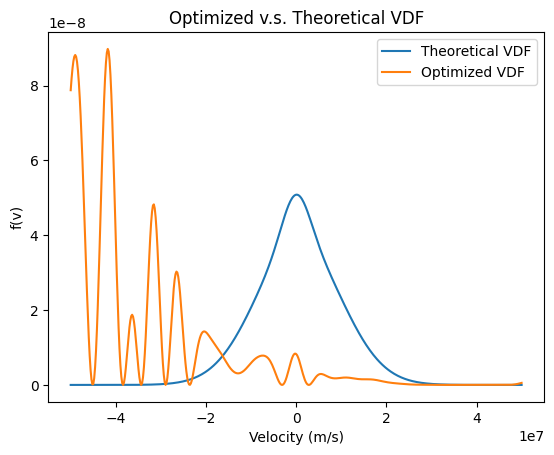

tensor(1., device='cuda:0')


In [32]:
efn_optim = reconstruct_from_coeffs(e_velocity_axis_TORCH, e_vd_optim, e_scale_optim, hermite_functions, e_c0_optim, e_c1_optim, e_c2_optim, e_c3_optim, e_c4_optim, 
                                    e_c5_optim, e_c6_optim, e_c7_optim, e_c8_optim, e_c9_optim, e_c10_optim, e_c11_optim, e_c12_optim, e_c13_optim, e_c14_optim, e_c15_optim, 
                                    e_c16_optim, e_c17_optim, e_c18_optim, e_c19_optim, e_c20_optim, e_c21_optim, e_c22_optim, e_c23_optim, e_c24_optim, e_c25_optim, e_c26_optim, e_c27_optim)

plt.plot(e_velocity_axis_TORCH.cpu(), fe_in, label='Theoretical VDF')
plt.plot(e_velocity_axis_TORCH.cpu(), efn_optim.cpu(), label='Optimized VDF')


plt.title('Optimized v.s. Theoretical VDF')
plt.xlabel('Velocity (m/s)')
plt.ylabel('f(v)')
plt.legend()
plt.show()

print(torch.trapz(efn_optim, e_velocity_axis_TORCH))

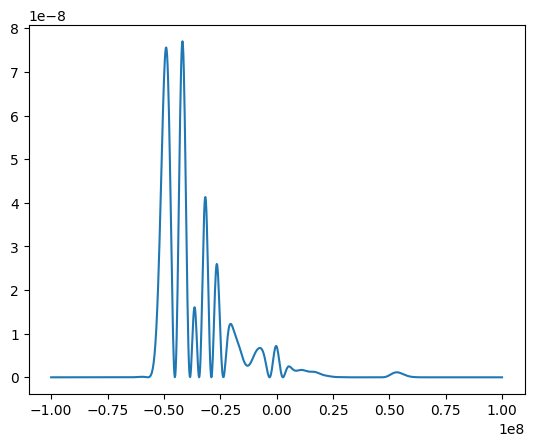

In [35]:
bonus_axis = torch.linspace(-1e8,1e8, 1000)

efn_extended = reconstruct_from_coeffs(bonus_axis, e_vd_optim, e_scale_optim, hermite_functions, e_c0_optim, e_c1_optim, e_c2_optim, e_c3_optim, e_c4_optim, 
                                    e_c5_optim, e_c6_optim, e_c7_optim, e_c8_optim, e_c9_optim, e_c10_optim, e_c11_optim, e_c12_optim, e_c13_optim, e_c14_optim, e_c15_optim, 
                                    e_c16_optim, e_c17_optim, e_c18_optim, e_c19_optim, e_c20_optim, e_c21_optim, e_c22_optim, e_c23_optim, e_c24_optim, e_c25_optim, e_c26_optim, e_c27_optim)

plt.plot(bonus_axis.cpu(), efn_extended.cpu())

## 3.4. Generate Initial IAW S'

In [ ]:
# Enable gradient tracking for ion parameters
if NUM_FREE_PARAMS == NUM_PARAMS:
    for param in ion_params: ion_params[param].requires_grad=True
else:
    for i in range(NUM_FREE_PARAMS-NUM_ELECTRON_PARAMS): ion_params[ion_param_keys[i]].requires_grad=True

In [ ]:
efn_optim = reconstruct_from_coeffs(e_velocity_axis_TORCH, e_vd_optim, e_scale_optim, hermite_functions, e_c0_optim, e_c1_optim, e_c2_optim, e_c3_optim, e_c4_optim, 
                                    e_c5_optim, e_c6_optim, e_c7_optim, e_c8_optim, e_c9_optim, e_c10_optim, e_c11_optim, e_c12_optim, e_c13_optim, e_c14_optim, e_c15_optim, 
                                    e_c16_optim, e_c17_optim, e_c18_optim, e_c19_optim, e_c20_optim, e_c21_optim, e_c22_optim, e_c23_optim, e_c24_optim, e_c25_optim, e_c26_optim, e_c27_optim)
#efn_optim = bimaxwellian_e_TORCH(e_velocity_axis_TORCH, torch.tensor([50.]), torch.tensor([0.]), torch.tensor([500.]), torch.tensor([5e5]), torch.tensor([1/11]))
efn_iaw = [efn_optim]
#n_optim = torch.tensor([2.1e25])


ifn = reconstruct_from_coeffs(i_velocity_axis_TORCH, ion_params["i_vd"], torch.exp(ion_params["ln_i_scale"]), hermite_functions,
                           ion_params["i_c0"], ion_params["i_c1"], ion_params["i_c2"], ion_params["i_c3"],ion_params["i_c4"],
                           ion_params["i_c5"], ion_params["i_c6"], ion_params["i_c7"], ion_params["i_c8"],ion_params["i_c9"],
                           ion_params["i_c10"], ion_params["i_c11"],ion_params["i_c12"], ion_params["i_c13"],ion_params["i_c14"],
                           ion_params["i_c15"], ion_params["i_c16"],ion_params["i_c17"], ion_params["i_c18"],ion_params["i_c19"],
                           ion_params["i_c20"], ion_params["i_c21"],ion_params["i_c22"], ion_params["i_c23"],ion_params["i_c24"],
                           ion_params["i_c25"], ion_params["i_c26"],ion_params["i_c27"])

ifn_iaw = [ifn]

#ifract_TORCH = [1-ion_params["i1_fract"]-ion_params["i2_fract"], ion_params["i1_fract"], ion_params["i2_fract"]]
ifract_TORCH = torch.tensor([1.], dtype=torch.float64)


# Call forward model function to generate initial IAW S'
_, Skw_arbdist_iaw = cpu_autodiff_thomson.spectral_density_arbdist(
    iaw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    i_velocity_axes_TORCH,
    efn_iaw,
    ifn_iaw,
    derivative_matrices,
    n_optim,
    iaw_notch,
    efract_TORCH,
    ifract_TORCH,
    ion_species_TORCH,
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8,
)

In [ ]:
fH_in_TORCH = maxwellian_H_TORCH(vH_TORCH, torch.tensor(400.), torch.tensor(5.0e5))
fC_in_TORCH = maxwellian_C_TORCH(vH_TORCH, torch.tensor(400.), torch.tensor(5.0e5))

ifn_semi_iaw = [fH_in_TORCH, fC_in_TORCH]


_, Skw_semi_iaw = cpu_autodiff_thomson.spectral_density_arbdist(
    iaw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    [i_velocity_axis_TORCH, i_velocity_axis_TORCH],
    efn_iaw,
    ifn_semi_iaw,
    derivative_matrices,
    n_optim,
    iaw_notch,
    efract_TORCH,
    [torch.tensor(9/10), torch.tensor(1/10)],
    ["p", "C-12 5+"],
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8,
)

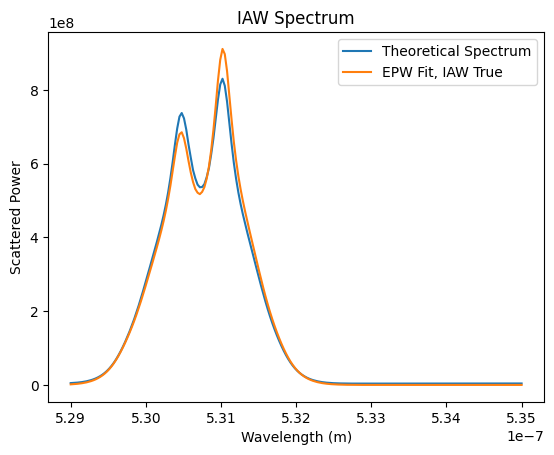

In [ ]:
plt.plot(iaw_wavelengths_TORCH.cpu().numpy(), iaw_target.cpu(), label = "Theoretical Spectrum")
plt.plot(iaw_wavelengths_TORCH.cpu().numpy(), Skw_semi_iaw.detach().cpu().numpy(), label = "EPW Fit, IAW True")
plt.legend(loc = "upper right")
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("IAW Spectrum")
plt.show()

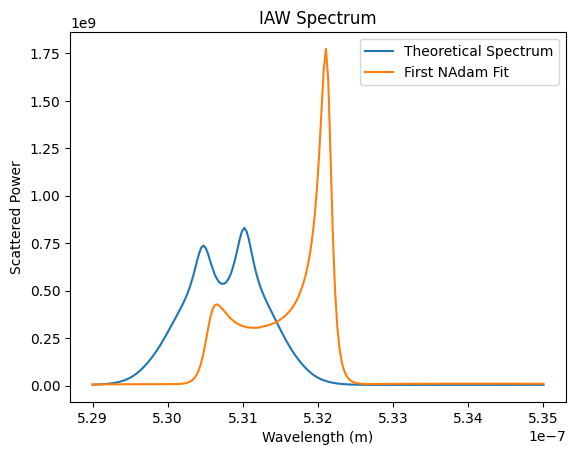

In [ ]:
plt.plot(iaw_wavelengths_TORCH.cpu().numpy(), iaw_target.cpu(), label = "Theoretical Spectrum")
plt.plot(iaw_wavelengths_TORCH.cpu().numpy(), Skw_arbdist_iaw.detach().cpu().numpy(), label = "First NAdam Fit")
plt.legend(loc = "upper right")
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("IAW Spectrum")
plt.show()

## 3.5. Optimize IAW Spectrum

In [ ]:
# Construct optimizer for IAW parameters
#opt_iaw = torch.optim.NAdam([
#        {'params': (ion_params["i0_vd"], ion_params["ln_i2_T"], ion_params["ln_i1_T"], ion_params["ln_i0_T"]), "lr":1e-3},
#        {'params': (ion_params["i1_fract"], ion_params["i2_fract"]), "lr":1e-4},
#        {'params': (ion_params["i2_vd"], ion_params["i1_vd"]), "lr":100}
#      ], lr=1e-3, betas=[0.9985, 0.999])

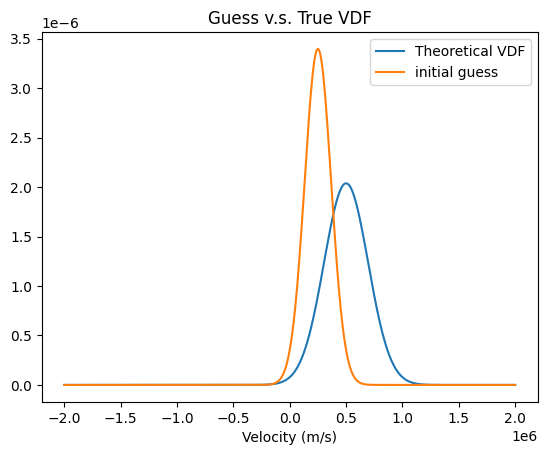

tensor(1.0000, device='cuda:0', grad_fn=<DivBackward1>)


In [ ]:
plt.plot(i_velocity_axis_TORCH.cpu(), fH_in, label='Theoretical VDF')
plt.plot(i_velocity_axis_TORCH.cpu().numpy(), ifn.detach().cpu().numpy(), label='initial guess')
plt.title('Guess v.s. True VDF')
plt.xlabel('Velocity (m/s)')
plt.legend()
plt.show()

print(torch.trapz(ifn, i_velocity_axis_TORCH))

In [ ]:
from collections import defaultdict

# Group parameters based on substrings or naming convention
grouped_ion_params = defaultdict(list)
for name, param in ion_params.items():
    if "vd" in name:
        grouped_ion_params["drift_velocities"].append(param)
    elif "scale" in name:
        grouped_ion_params["scale"].append(param)
    elif "_c" in name:
        grouped_ion_params["coeffs"].append(param)

# Construct optimizer using grouped parameters
opt_iaw = torch.optim.NAdam([
    {'params': grouped_ion_params["drift_velocities"], 'lr': 10},
    {'params': grouped_ion_params["scale"], 'lr': 1e-3},
    {'params': grouped_ion_params["coeffs"], 'lr': 1e-3}
], betas=[0.9985, 0.999])


In [ ]:
# Calculate initial IAW loss
iaw_target = iaw_target.to(Skw_arbdist_iaw.device)

iaw_dist_hist = [Skw_arbdist_iaw.detach().clone()]
iaw_loss_hist = [float(dist_score(Skw_arbdist_iaw, iaw_target).detach())]
print(iaw_loss_hist)

[209.34640566402146]


In [ ]:
# Construct fitted electron VDF now to save redundant calls
#efn_optim = bimaxwellian_e_TORCH(e_velocity_axis_TORCH, e_T1_optim, e_vd1_optim, e_T2_optim, e_vd2_optim, e_n1_optim)
#efn_optim = bimaxwellian_e_TORCH(e_velocity_axis_TORCH, torch.tensor([50.]), torch.tensor([0.]), torch.tensor([500.]), torch.tensor([5e5]), torch.tensor([1/11]))
efn_iaw = [efn_optim]
#n_optim = torch.tensor([2.1e25])

iaw_counter = 0
while True:
#for i in trange(6000):
    opt_iaw.zero_grad()

    # Reconstruct ion velocity distributions using updated Ts and vds
    #fH_ambient = maxwellian_H_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i0_T"]), ion_params["i0_vd"])
    #fH_piston = maxwellian_H_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i1_T"]), ion_params["i1_vd"])
    #fC_piston = maxwellian_C_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i2_T"]), ion_params["i2_vd"])
    #ifn_iaw = [fH_ambient, fH_piston, fC_piston]

    #ion_params["i0_fract"] = 1-ion_params["i1_fract"]-ion_params["i2_fract"]
    #ifract_TORCH = [ion_params["i0_fract"], ion_params["i1_fract"], ion_params["i2_fract"]]
    #ifract_TORCH = [torch.tensor([1/71], dtype=torch.float64), torch.tensor([10/71], dtype=torch.float64), torch.tensor([60/71], dtype=torch.float64)] (dont put back)

    ifn = reconstruct_from_coeffs(i_velocity_axis_TORCH, ion_params["i_vd"], torch.exp(ion_params["ln_i_scale"]), hermite_functions,
                           ion_params["i_c0"], ion_params["i_c1"], ion_params["i_c2"], ion_params["i_c3"],ion_params["i_c4"],
                           ion_params["i_c5"], ion_params["i_c6"], ion_params["i_c7"], ion_params["i_c8"],ion_params["i_c9"],
                           ion_params["i_c10"], ion_params["i_c11"],ion_params["i_c12"], ion_params["i_c13"],ion_params["i_c14"],
                           ion_params["i_c15"], ion_params["i_c16"],ion_params["i_c17"], ion_params["i_c18"],ion_params["i_c19"],
                           ion_params["i_c20"], ion_params["i_c21"],ion_params["i_c22"], ion_params["i_c23"],ion_params["i_c24"],
                           ion_params["i_c25"], ion_params["i_c26"],ion_params["i_c27"])

    ifn_iaw = [ifn]

    _, Skw_arbdist_iaw = cpu_autodiff_thomson.spectral_density_arbdist(
    iaw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    i_velocity_axes_TORCH,
    efn_iaw,
    ifn_iaw,
    derivative_matrices,
    n_optim,
    iaw_notch,
    efract_TORCH,
    ifract_TORCH,
    ion_species_TORCH,
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8,
    )

    # Caculate NMSE
    iaw_loss = dist_score(Skw_arbdist_iaw, iaw_target)
    opt_iaw.step()

    # Append value to loss history
    iaw_dist_hist.append(Skw_arbdist_iaw.detach().clone())
    iaw_loss_hist.append(float(iaw_loss.detach()))

    iaw_counter += 1

    # Check if criteria of convergence is met
    delta_NMSE = abs(iaw_loss_hist[iaw_counter] - iaw_loss_hist[iaw_counter-1])
    if delta_NMSE <= IAW_CUTOFF_CRITERIA and iaw_counter > MIN_NUM_ITERS:
        print(f"Exiting loop after {iaw_counter} iterations, loss is {delta_NMSE}")
        break

KeyboardInterrupt: 

Text(0.5, 1.0, 'IAW Loss History')

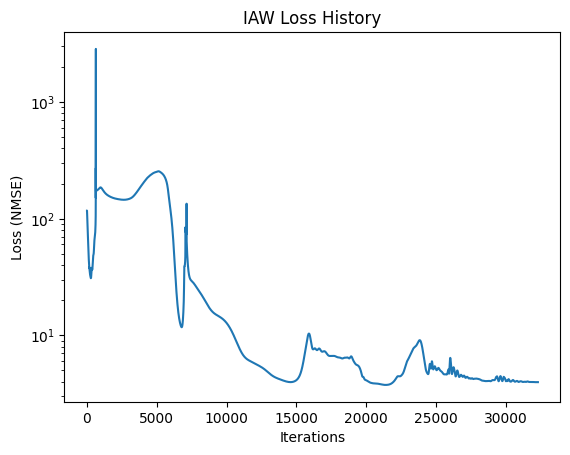

In [ ]:
# Plot IAW loss history
#plt.semilogy(iaw_loss_hist)#[-1000:])
plt.semilogy([loss.item() if hasattr(loss, 'item') else loss for loss in iaw_loss_hist])
plt.xlabel("Iterations")
plt.ylabel("Loss (NMSE)")
plt.title("IAW Loss History")

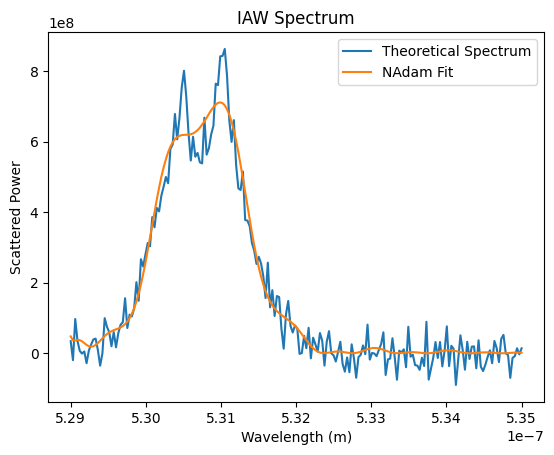

In [ ]:
# Plot fitted IAW spectrum
plt.plot(iaw_wavelengths_TORCH.cpu().numpy(), iaw_target.cpu(), label="Theoretical Spectrum")
plt.plot(iaw_wavelengths_TORCH.cpu().numpy(), Skw_arbdist_iaw.detach().cpu().numpy(), label="NAdam Fit")
plt.legend(loc="upper right")
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("IAW Spectrum")
plt.show()

In [ ]:
print(iaw_loss_hist[-1])

3.9577989329420795


In [ ]:
# Print optimized EPW parameters
i_vd_optim = ion_params["i_vd"].detach().clone()
i_scale_optim = torch.exp(ion_params["ln_i_scale"]).detach().clone()


i_c0_optim = ion_params["i_c0"].detach().clone()
i_c1_optim = ion_params["i_c1"].detach().clone()
i_c2_optim = ion_params["i_c2"].detach().clone()
i_c3_optim = ion_params["i_c3"].detach().clone()
i_c4_optim = ion_params["i_c4"].detach().clone()
i_c5_optim = ion_params["i_c5"].detach().clone()
i_c6_optim = ion_params["i_c6"].detach().clone()
i_c7_optim = ion_params["i_c7"].detach().clone()
i_c8_optim = ion_params["i_c8"].detach().clone()
i_c9_optim = ion_params["i_c9"].detach().clone()
i_c10_optim = ion_params["i_c10"].detach().clone()
i_c11_optim = ion_params["i_c11"].detach().clone()
i_c12_optim = ion_params["i_c12"].detach().clone()
i_c13_optim = ion_params["i_c13"].detach().clone()
i_c14_optim = ion_params["i_c14"].detach().clone()
i_c15_optim = ion_params["i_c15"].detach().clone()
i_c16_optim = ion_params["i_c16"].detach().clone()
i_c17_optim = ion_params["i_c17"].detach().clone()
i_c18_optim = ion_params["i_c18"].detach().clone()
i_c19_optim = ion_params["i_c19"].detach().clone()
i_c20_optim = ion_params["i_c20"].detach().clone()
i_c21_optim = ion_params["i_c21"].detach().clone()
i_c22_optim = ion_params["i_c22"].detach().clone()
i_c23_optim = ion_params["i_c23"].detach().clone()
i_c24_optim = ion_params["i_c24"].detach().clone()
i_c25_optim = ion_params["i_c25"].detach().clone()
i_c26_optim = ion_params["i_c26"].detach().clone()
i_c27_optim = ion_params["i_c27"].detach().clone()


print("i_vd_true = ", i_vd_optim)
print("i_scale_true = ", i_scale_optim)
print("i_c0_true = ", i_c0_optim)
print("i_c1_true = ", i_c1_optim)
print("i_c2_true = ", i_c2_optim)
print("i_c3_true = ", i_c3_optim)
print("i_c4_true = ", i_c4_optim)
print("i_c5_true = ", i_c5_optim)
print("i_c6_true = ", i_c6_optim)
print("i_c7_true = ", i_c7_optim)
print("i_c8_true = ", i_c8_optim)
print("i_c9_true = ", i_c9_optim)
print("i_c10_true = ", i_c10_optim)
print("i_c11_true = ", i_c11_optim)
print("i_c12_true = ", i_c12_optim)
print("i_c13_true = ", i_c13_optim)
print("i_c14_true = ", i_c14_optim)
print("i_c15_true = ", i_c15_optim)
print("i_c16_true = ", i_c16_optim)
print("i_c17_true = ", i_c17_optim)
print("i_c18_true = ", i_c18_optim)
print("i_c19_true = ", i_c19_optim)
print("i_c20_true = ", i_c20_optim)
print("i_c21_true = ", i_c21_optim)
print("i_c22_true = ", i_c22_optim)
print("i_c23_true = ", i_c23_optim)
print("i_c24_true = ", i_c24_optim)
print("i_c25_true = ", i_c25_optim)
print("i_c26_true = ", i_c26_optim)
print("i_c27_true = ", i_c27_optim)

i_vd_true =  tensor([235772.0761], device='cuda:0')
i_scale_true =  tensor([470077.6802], device='cuda:0')
i_c0_true =  tensor([1.2529], device='cuda:0')
i_c1_true =  tensor([-0.9181], device='cuda:0')
i_c2_true =  tensor([0.5957], device='cuda:0')
i_c3_true =  tensor([-0.9383], device='cuda:0')
i_c4_true =  tensor([1.4256], device='cuda:0')
i_c5_true =  tensor([-1.3074], device='cuda:0')
i_c6_true =  tensor([-0.0377], device='cuda:0')
i_c7_true =  tensor([0.9831], device='cuda:0')
i_c8_true =  tensor([-1.8827], device='cuda:0')
i_c9_true =  tensor([0.8331], device='cuda:0')
i_c10_true =  tensor([0.5757], device='cuda:0')
i_c11_true =  tensor([-2.0564], device='cuda:0')
i_c12_true =  tensor([2.1988], device='cuda:0')
i_c13_true =  tensor([-0.2001], device='cuda:0')
i_c14_true =  tensor([-1.1290], device='cuda:0')
i_c15_true =  tensor([1.9406], device='cuda:0')
i_c16_true =  tensor([-0.2650], device='cuda:0')
i_c17_true =  tensor([-1.8705], device='cuda:0')
i_c18_true =  tensor([1.9314]

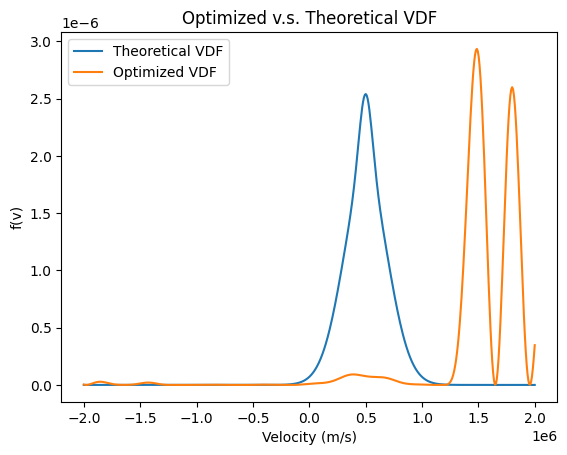

In [ ]:
ifn_optim = reconstruct_from_coeffs(i_velocity_axis_TORCH, i_vd_optim, i_scale_optim, hermite_functions, i_c0_optim, i_c1_optim, i_c2_optim, i_c3_optim, i_c4_optim,
                                    i_c5_optim, i_c6_optim, i_c7_optim, i_c8_optim, i_c9_optim, i_c10_optim, i_c11_optim, i_c12_optim, i_c13_optim, i_c14_optim, i_c15_optim,
                                    i_c16_optim, i_c17_optim, i_c18_optim, i_c19_optim, i_c20_optim, i_c21_optim, i_c22_optim, i_c23_optim, i_c24_optim, i_c25_optim, i_c26_optim, i_c27_optim)


plt.plot(i_velocity_axis_TORCH.cpu(), (9/10) * fH_in + (1/10) * fC_in, label='Theoretical VDF')
plt.plot(i_velocity_axis_TORCH.cpu(), ifn_optim.cpu(), label='Optimized VDF')




plt.title('Optimized v.s. Theoretical VDF')
plt.xlabel('Velocity (m/s)')
plt.ylabel('f(v)')
plt.legend()
plt.show()
